In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
import numpy as np
import torch

from pytorch3d.datasets import (
    R2N2,
    ShapeNetCore,
    collate_batched_meshes,
    render_cubified_voxels,
)
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform,
)

from pytorch3d.structures import Meshes
from torch.utils.data import DataLoader

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [3]:
#!curl -o ./plot_image_grid.py https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

In [4]:
import warnings
warnings.filterwarnings('always')

In [5]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
    
SHAPENET_PATH = ".\\shapenet\\ShapeNetCore.v2"
shapenet_dataset = ShapeNetCore(SHAPENET_PATH, version=2)

C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: ObjectXXX file not found in the model directory 207e69af994efa9330714334794526d4 under synset directory 02958343 data .\shapenet\ShapeNetCore.v2 modeldir models/model_normalized.obj is complete .\shapenet\ShapeNetCore.v2\02958343\207e69af994efa9330714334794526d4\models/model_normalized.obj.
  warnings.warn(msg)
C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: ObjectXXX file not found in the model directory 2307b51ca7e4a03d30714334794526d4 under synset directory 02958343 data .\shapenet\ShapeNetCore.v2 modeldir models/model_normalized.obj is complete .\shapenet\ShapeNetCore.v2\02958343\2307b51ca7e4a03d30714334794526d4\models/model_normalized.obj.
  warnings.warn(msg)
C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.

In [13]:
shapenet_model = shapenet_dataset[6]
print("This model belongs to the category " + shapenet_model["synset_id"] + ".")
print("This model has model id " + shapenet_model["model_id"] + ".")
model_verts, model_faces = shapenet_model["verts"], shapenet_model["faces"]

This model belongs to the category 03642806.
This model has model id 1312ea502b4e9b51701c1f58e22b85e8.


C:\Dev\Tools\Python\Env\pt399\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


We can use its vertices and faces to form a `Meshes` object which is a PyTorch3D datastructure for working with batched meshes.

In [14]:
model_textures = TexturesVertex(verts_features=torch.ones_like(model_verts, device=device)[None])
shapenet_model_mesh = Meshes(
    verts=[model_verts.to(device)],   
    faces=[model_faces.to(device)],
    textures=model_textures
)

## 2. Use the datasets with `torch.utils.data.DataLoader`

Training deep learning models, usually requires passing in batches of inputs. The `torch.utils.data.DataLoader` from PyTorch helps us do this. PyTorch3D provides a function `collate_batched_meshes` to group the input meshes into a single `Meshes` object which represents the batch. The `Meshes` datastructure can then be used directly by other PyTorch3D ops which might be part of the deep learning model (e.g. `graph_conv`).


## 3. Render ShapeNetCore models with PyTorch3D's differentiable renderer

Both `ShapeNetCore` and `R2N2` dataloaders have customized `render` functions that support rendering models by specifying their model ids, categories or indices using PyTorch3D's differentiable renderer implementation.

In [15]:
# Rendering settings.
R, T = look_at_view_transform(1.0, 1.0, 90)
cameras = OpenGLPerspectiveCameras(R=R, T=T, device=device)
raster_settings = RasterizationSettings(image_size=512)
lights = PointLights(location=torch.tensor([0.0, 1.0, -2.0], device=device)[None],device=device)

C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\renderer\cameras.py:439: PendingDeprecationWarning: OpenGLPerspectiveCameras is deprecated,
        Use FoVPerspectiveCameras instead.
        OpenGLPerspectiveCameras will be removed in future releases.
  warnings.warn(


First we will try to render three models by their model ids:

C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\io\mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)
C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\io\mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


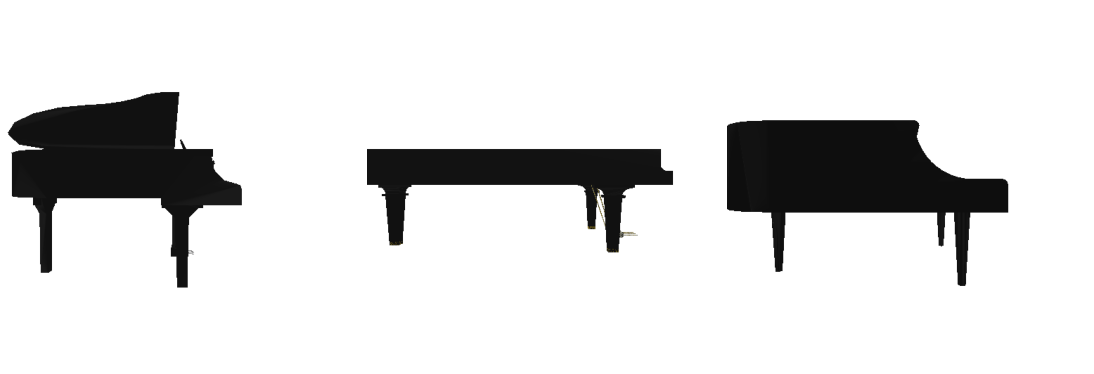

In [16]:
images_by_model_ids = shapenet_dataset.render(
    model_ids=[
        "13394ca47c89f91525a3aaf903a41c90",
        "14755c2ee8e693aba508f621166382b0",
        "156c4207af6d2c8f1fdc97905708b8ea",
    ],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_model_ids.cpu().numpy(), rows=1, cols=3, rgb=True)

Suppose we would like to render the first three models in the dataset, we can render models by their indices:

C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\io\mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


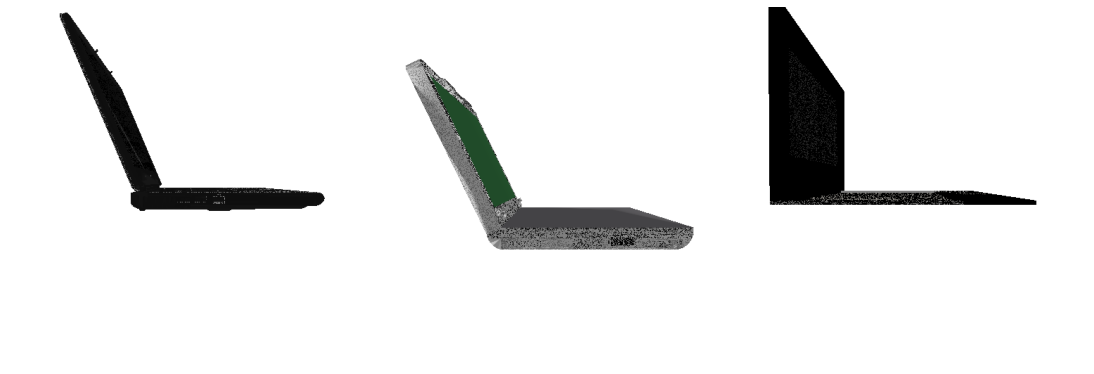

In [17]:
images_by_idxs = shapenet_dataset.render(
    idxs=list(range(3)),
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_idxs.cpu().numpy(), rows=1, cols=3, rgb=True)

C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\io\mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)
C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\io\mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)
C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\io\mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)
C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\io\mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].        

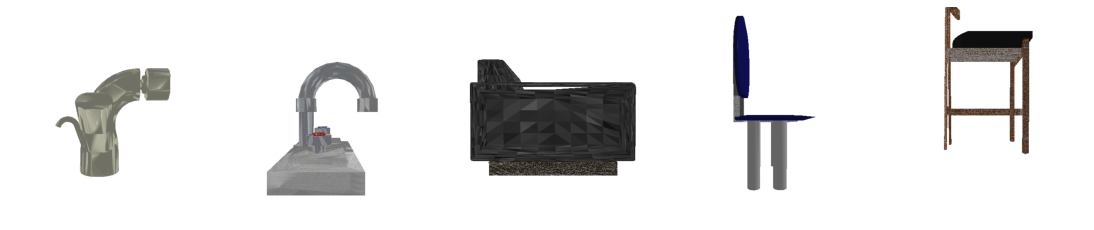

In [18]:
images_by_categories = shapenet_dataset.render(
    categories=["faucet", "chair"],
    sample_nums=[2, 3],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_categories.cpu().numpy(), rows=1, cols=5, rgb=True)

C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\io\mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)
C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\io\mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)
C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\io\mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)
C:\Dev\Tools\Python\Env\pt399\lib\site-packages\pytorch3d-0.6.1-py3.9-win-amd64.egg\pytorch3d\io\mtl_io.py:101: UserWarning: Texture UV coordinates outside the range [0, 1].        

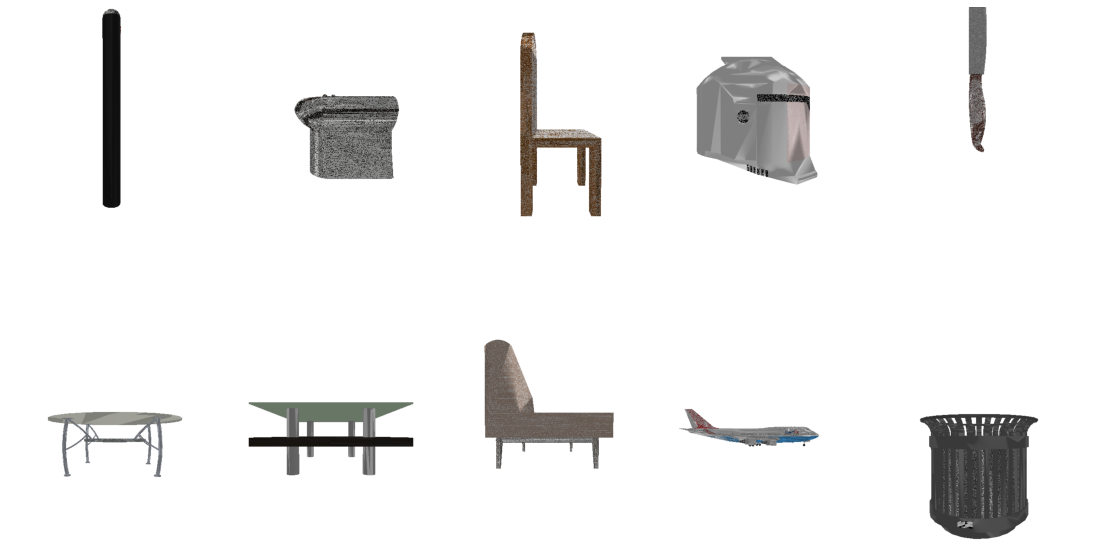

In [21]:
random_model_images = shapenet_dataset.render(
    sample_nums=[10],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(random_model_images.cpu().numpy(), rows=2, cols=5, rgb=True)